沿着美国与墨西哥的边界，有四个州加州（CA）、亚利桑那州（AZ）、新墨西哥州（NM）和得克萨斯州（TX）希望制定一个现实的新能源契约，重点是增加清洁、可再生能源的使用。你的团队被这四个州的州长要求通过进行数据分析和建模，告知他们为州际能源契约制定一系列的目标。

附加的数据文件“ProblemCData.xlsx”，在其第一份工作表（seseds)中提供了**这四个国家50年能源生产和消费方面的 605 个变量的数据**，以及一些人口和经济信息。这个数据集中使用的 605 个变量名在第二个工作表（“msncodes”）中定义。

第一部分：
1. 利用所给的数据，为每个州建立一个能源概况。
2. 建立一个模型来描述这四个州从1960年到2009年的能源概况的变化。分析并解释你的模型结果，以一种易于州长理解的方式来说明四个州使用清洁的、可再生能源的情况，并帮助他们理解这四个州之间的异同。在你们的讨论中包括可能影响相似性和差异性的因素(如地理，工业，人口和气候)。
3. 确定这四个州中哪一个州在2009年使用清洁、可再生能源方面表现“最好”。并解释你的评价标准和选择原因。
4. 根据这些州能源使用情况的历史演变，以及对你所建立的各州概况之间的差异的理解，在各州都没有任何政策调整的情况下，预测2025年和2050年每个州的能源概况。

第二部分：
1. 根据你对这四个州的比较，你的最佳概况评判标准，以及你的预测，确定2025年和2050年的可再生能源使用目标，并将其作为这四个州新能源契约的目标来陈述。
2. 确定并讨论至少三项四个州可能需要采取的行动，以实现他们的能源契约目标。


![边境四州](https://s3.ax1x.com/2021/01/22/s5RruV.png)

首先进行数据分析

# 第一部分

In [12]:
import pandas as pd
import numpy as np
import xlrd
from math import radians, cos, sin, asin, sqrt
import xlwt
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns
import copy
import random
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

import time

#pd.set_option('display.max_rows', None)
pd.reset_option("display.max_rows")

# 不用科学计数
# pd.set_option('display.float_format',lambda x : '%.2f' % x)

Loading BokehJS ...

In [23]:
pd.isnull(origin_data).sum()

MSN          0
StateCode    0
Year         0
Data         0
dtype: int64

简单分析发现没有缺失项

## 指标分析以CA州为例，建立能源概况energy profile

In [2]:
origin_data=pd.read_excel('ProblemCData.xlsx',sheet_name='seseds')

- Billion Btu       BTU是英国能源单位，含有这个的肯定是能源的量
- Dollars          这个只有一个，Total energy expenditures per capita.人均能源支出总额
- Dollars per million Btu    每million BTU的价格，应当是该年份该能源价格
- Million Btu       同样代表能源，只有一个Total energy consumption per capita.人均能源总消耗
- Million Btu per barrel  所包含这一类的都代表着能源实际单位(主要是油类)到BTU的换算，起到统一度量的作用，应该可以舍去
- Million Btu per short ton  同上，也为单位换算，是针对煤的
- Million chained (2005) dollars  **只有一项，实际国内生产总值GDPRX**
- Million cubic feet   百万立方英尺，用来衡量天然气等气体能源
- Million dollars     大多是各种能源的财政支出
- Million kilowatthours 电力相关
- Percent           占比，只有一个：能源支出占当期美元国内生产总值的比例。TEGDS
- Thousand          只有一个，包括武装部队在内的常住人口。TPOPP，
- Thousand barrels    以桶为单位的能源消耗
- Thousand Btu per chained (2000) dollar 只有一个:每一美元实际国内生产总值所消耗的能源总量TETGR。
- Thousand Btu per cubic feet   只有一个:天然气市场化生产的换算系数NGMPK
- Thousand Btu per cubic foot   只有一类：天然气的转换系数
- Thousand Btu per kilowatthour  只有一类：电力的转换系数，舍去，在seseds中都找不到对应项
- Thousand cords       只有一个，木材消耗
- Thousand short tons    煤炭类

In [3]:
data_explain=pd.read_excel('ProblemCData.xlsx',sheet_name='msncodes')

,MSN,Description,Unit
0,ABICB,Aviation gasoline blending components consumed...,Billion Btu
1,ABICP,Aviation gasoline blending components consumed...,Thousand barrels
2,ARICB,Asphalt and road oil consumed by the industria...,Billion Btu
3,ARICD,Asphalt and road oil price in the industrial s...,Dollars per million Btu
4,ARICP,Asphalt and road oil consumed by the industria...,Thousand barrels
...,...,...,...
600,WXICP,Waxes consumed by the industrial sector.,Thousand barrels
601,WXICV,Waxes expenditures in the industrial sector.,Million dollars
602,WYEGB,Electricity produced from wind energy by the e...,Billion Btu
603,WYEGP,Electricity produced from wind energy by the e...,Million kilowatthours


In [7]:
btu_MSN=[]
for index,item in data_explain.iterrows():
    if item['Unit']=='Billion Btu':
        btu_MSN.append(item['MSN'])

['ABICB',
 'ARICB',
 'ARTCB',
 'ARTXB',
 'AVACB',
 'AVTCB',
 'AVTXB',
 'BMTCB',
 'CCEXB',
 'CCIMB',
 'CCNIB',
 'CLACB',
 'CLCCB',
 'CLEIB',
 'CLICB',
 'CLKCB',
 'CLOCB',
 'CLOSB',
 'CLPRB',
 'CLRCB',
 'CLRFB',
 'CLTCB',
 'CLTXB',
 'COICB',
 'DFACB',
 'DFCCB',
 'DFICB',
 'DFISB',
 'DFRCB',
 'DFRFB',
 'DFTCB',
 'DFTXB',
 'DKEIB',
 'ELEXB',
 'ELIMB',
 'ELISB',
 'ELNIB',
 'EMACB',
 'EMCCB',
 'EMFDB',
 'EMICB',
 'EMLCB',
 'EMTCB',
 'ESACB',
 'ESCCB',
 'ESICB',
 'ESISB',
 'ESRCB',
 'ESRFB',
 'ESTCB',
 'ESTXB',
 'FFTCB',
 'FNICB',
 'FOICB',
 'FSICB',
 'GECCB',
 'GEEGB',
 'GEICB',
 'GERCB',
 'GETCB',
 'GETXB',
 'GOCCB',
 'GORCB',
 'HYCCB',
 'HYEGB',
 'HYICB',
 'HYTCB',
 'HYTXB',
 'JFACB',
 'JFTCB',
 'JFTXB',
 'JKACB',
 'JKTCB',
 'JNACB',
 'JNTCB',
 'KSCCB',
 'KSICB',
 'KSRCB',
 'KSTCB',
 'KSTXB',
 'LGACB',
 'LGCCB',
 'LGICB',
 'LGISB',
 'LGRCB',
 'LGRFB',
 'LGTCB',
 'LGTXB',
 'LOACB',
 'LOCCB',
 'LOICB',
 'LORCB',
 'LOTCB',
 'LOTXB',
 'LUACB',
 'LUICB',
 'LUTCB',
 'LUTXB',
 'MBICB',
 'MGACB',


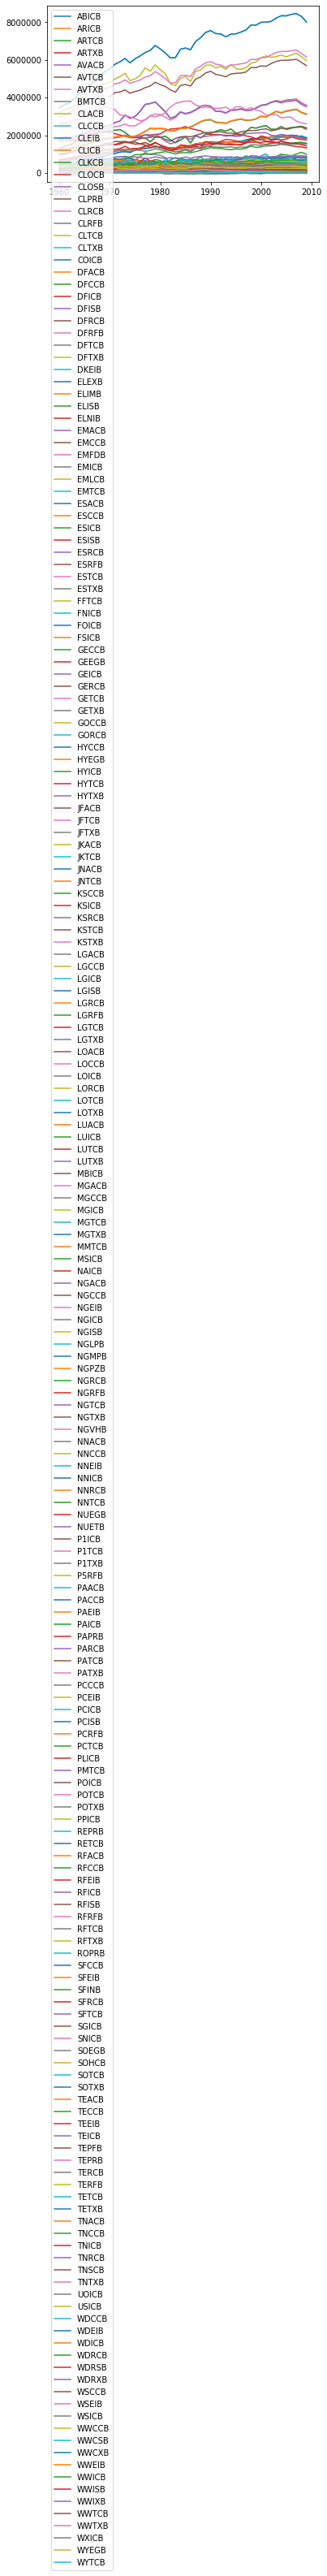

In [45]:
data_CA=origin_data[origin_data['StateCode']=='CA']
no_data_MSN=[]
#has_data_MSN=[]
for MSN in btu_MSN:
    data_CA_single_MSN=data_CA[data_CA['MSN']==MSN]
    year=data_CA_single_MSN['Year']
    data=data_CA_single_MSN['Data']
    try:
        plt.plot(year,data,label=data_CA_single_MSN['MSN'].iloc[0])
        plt.legend()
        #has_data_MSN.append(MSN)
    except:
        no_data_MSN.append(MSN)
plt.show()

剔除了三个无用指标见no_data_MSN

考虑第一问如何建立每个州的能源概况，应当是倾向于作图展示。指标的建立参考自[中国统计年鉴2020](http://www.stats.gov.cn/tjsj/ndsj/2020/indexch.htm)的能源部分与国家统计局的[能源指标解释](http://www.stats.gov.cn/tjsj/zbjs/201912/t20191202_1713052.html)

### 一次能源生产总量

指一定时期内，全国一次能源生产量的总和。该指标是观察全国能源生产水平、规模、构成和发展速度的总量指标。包括：

原煤、原油、天然气、水电、核能及其他动力能(如风能、地热能等)发电量等，

不包括低热值燃料生产量和由一次能源加工转换而成的二次能源产量。

一次能源细分为可再生能源与非可再生能源

对应指标有：
- TEPRB 能源生产总量（应当是仅包含一次能源）

非可再生
- CLPRB 煤炭产量
- NGMPB Natural gas marketed production.天然气产量（存疑）
- PAPRB 原油生产（包括租赁的凝析油）
- NUETB 核能发电

可再生
- REPRB 可再生能源总产量
- GEEGB 电力部门利用地热能生产的电力
- HYTCB 水电总产量
- WYTCB 风力发电
- EMFDB 用于生产燃料乙醇的生物质投入（原料）

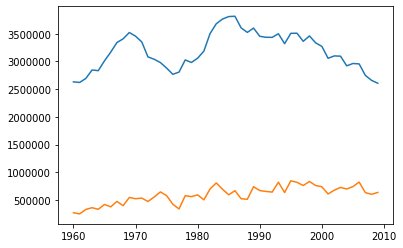

In [99]:
# 总能源产量
plt.plot(data_CA[data_CA['MSN']=='TEPRB']['Year'],data_CA[data_CA['MSN']=='TEPRB']['Data'],label='总能源')
plt.plot(data_CA[data_CA['MSN']=='REPRB']['Year'],data_CA[data_CA['MSN']=='REPRB']['Data'],label='可再生')
plt.show()

其余作图略

### 能源消费总量

在核算过程中，一次能源、二次能源消费不能重复计算。能源消费总量分为终端能源消费量、能源加工转换损失量和能源损失量三部分。

1. 终端能源消费量  end-use
2. 能源加工转换损失量  数据中暂无，故不考虑
3. 能源损失量

一次能源在数据中对应的是primary energy，查找即可。终端能源消费量在数据里对应的是关键词end-use，查找即可。能源损失量的关键词为loss

### 能源生产弹性系数

是研究能源生产增长速度与国民经济增长速度之间关系的指标。计算公式：
![](http://www.stats.gov.cn/tjsj/zbjs/201912/W020191202493513740741_r75.jpg)

分子对源数据做一次差分即可，分母根据[中国统计年鉴2020](http://www.stats.gov.cn/tjsj/ndsj/2020/indexch.htm)取的是国内生产总值GDP的增长率

数据中有关GDP的有两个，GDPRV和GDPRX，分别是名义GPD和实际GPD，为了省去通胀带来的影响以及方便与历史年份统一比较\[1\]，选择GDPRX

*\[1\]实际GDP是指生产物品和劳务的当年价格按基年价格计算的全部最终产品的市场价值。由于相同产品的价格在不同的年份会有所不同，因此，如果用名义GDP就无法对国民收入进行历史的比较。为了使一个国家或地区不同年份的GDP具有可比性，就需要以某一年的价格水平为基准，各年的GDP都按照这一价格水平来计算。*

GDPRX做一次差分同样得到增速

### 其余指标

- 电力消费弹性系数
- 电力生产弹性系数
- 能源消费弹性系数
- 能源加工转换效率
- 单位国内生产总值能耗
- 单位国内生产总值电耗

可根据年鉴目录![](https://s3.ax1x.com/2021/01/22/s5TNpF.png)


能源的进出口概况如何，各个行业的能源利用概况如何，不再一一赘述

问题的很大一部分向可再生能源的利用倾斜，因此针对可再生能源的指标分析是必不可少的。



建立一个模型来描述这四个州从1960年到2009年的能源概况的变化。分析并解释你的模型结果，以一种易于州长理解的方式来说明四个州使用清洁的、可再生能源的情况，并帮助他们理解这四个州之间的异同。在你们的讨论中包括可能影响相似性和差异性的因素(如地理，工业，人口和气候)。

## 能源变化概况
- 能源强度  EI 一次能源消费量/GDP总量 反映该州当前产业特征，高了则趋向第二产业，低了趋向第三产业
- 人均能源消耗量  PCEC
- 能源生产弹性系数  EPEC   反映该州发展趋势
- 能源消耗弹性系数  ECEC
- 清洁能源占比    CEP    (可再生+核能/总能源)
- 一次能源清洁性  PECI 天然气>石油>煤炭  故给予该州清洁性指标为：5*天然气占比+3*石油占比+2*煤炭占比
- 非清洁能源平衡度  NCEB   product-consume 为正表示顺差，为负表示逆差
- 清洁能源平衡度  CEB     同上

## 清洁性
$score=\alpha \cdot CEP+\beta \cdot PECI+\gamma \cdot e^{\eta \cdot EI}$

根据上式给四个州打分

## 预测

预测2025年和2050年每个州的能源概况，在这里由于州与州之间存在能源进出口，故认为能源消耗不依赖于生产产量，但能源生产作为一种出售的商品，必然受市场约束，故我们认为其应当是约束于以往的消耗量的。

为了综合多种指标带来的影响，选择使用VAR模型进行预测，可用python的statsmodels库

EC能源消耗：

$EC_t=\sum _{i=1}^n\alpha 1 _iEC_{t-i}+\sum _{i=1}^n\beta 1_iECEC_{t-i}+\sum _{i=1}^n\gamma 1_iTPOPP_{t-i}+\sum _{i=1}^n\lambda 1_iEI_{t-i}+b_1+\varepsilon _t$

EP能源生产：

$EP_t=\sum _{i=1}^n\alpha 2 _iEP_{t-i}+\sum _{i=1}^n\beta 2_iEPEC_{t-i}+\sum _{i=1}^n\gamma 2_iTPOPP_{t-i}+\sum _{i=1}^n\lambda 2 _iEC_{t-i}+b_2+\varepsilon _t$

根据VAR，上式可以写成矩阵模式，并舍去$\alpha,\beta$等参数，用矩阵$A_1,A_2$描述。